In [7]:
from __future__ import print_function, division
from builtins import range

import numpy as np


class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    assert(self.current_state() in self.all_states())

  def game_over(self):
    return (self.i, self.j) not in self.actions

  def all_states(self):
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost = -0.1):
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

In [8]:
import numpy as np

SMALL_ENOUGH = 1e-3 # threshold for convergence

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") 
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
0
1000
2000
3000
4000


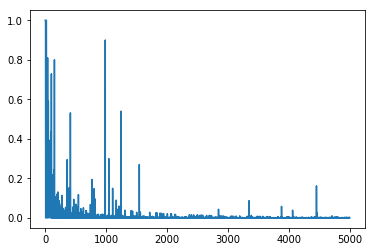

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  R  |  R  |
final values:
---------------------------
 0.57| 0.77| 1.00| 0.00|
---------------------------
 0.40| 0.00| 0.76| 0.00|
---------------------------
 0.25| 0.12|-1.00|-1.00|


In [12]:
import matplotlib.pyplot as plt

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# Implementing Monte Carlo Exploring-Starts method for finding the optimal policy

def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
 if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game(grid, policy):
    s = (2,0)
    grid.set_state(s)
    a = random_action(policy[s])
    states_actions_rewards = [(s, a, 0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()

        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s])
            states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
        
    states_actions_returns.reverse() # we want it to be in order of state visited
    return states_actions_returns


def max_dict(d):
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val


if __name__ == '__main__':
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(5000):
    if t % 1000 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    
    
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # first-visit MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
        a, _ = max_dict(Q[s])
        policy[s] = a

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)